# Phase mask optimization for single-molecule orientation measurement
Mar/06/2020 'Optimization_1emitter_VUB' organize the code; change to file name to 'optimization_1emitter_v2'

.... 'Optimization_1emitter_VUB' change to optimize only one molecules

Oct/23/2019 modefied for excitation and phase mask design simutaneously. only optimizaed on a spercific orientation state.

Nov/13/2019 extend the optimization. loss function is the sum of MSAE of several representative orientation state

Jan/8/2020  modify above codes, set VUB as the cost function, and remove the Electrical optimization part

## set the molecules information

this is the main cell, it includes the following parts

(1). initial setting for molecule

(2). basis matrix generation

(3). build model: initialize excitation and phase mask, final image generation with second excitation field moments and basis image

(4). the cost function defination--detectability and the CRB --go into the two cost functions

(5). optimization: the back projection process and update the electric field and the phase mask

(6). evaluate the optimization result

In [1]:
# import package
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import numpy as np
import cmath
from IPython.core.debugger import set_trace
#import pandas as pd 
from time import time, strftime, localtime
import scipy.io 
#import scipy.io
import warnings


tf.__version__  #note the script is developed under tensorflow=2.0


'2.0.0'

## Imaging system and Sample Parameters
feel free to modify the parameter below to match your experimental setup

In [2]:
signal=1000; #photons
background=2;

wavelength = 610e-9; # in unit of m
n1 = 1.518;
n2 = 1.334;
nh = 1.518;
NA = 1.4;
pixelSizeUpsampling = 1;
upsampling = 1;
pix_size=6500/pixelSizeUpsampling*1e-9; #in unit of m
bfp_radius = 80*upsampling;   #in unit of pixels
Magnitude = 111.1111;
sampling_size = round(1.541e5*wavelength*Magnitude*bfp_radius/NA)*pixelSizeUpsampling-1;
image_size = 31*pixelSizeUpsampling; #the final image is a 75 by 75 image, odd number



## part 1. basis image calculation

(a) Basis images at the back focal plane

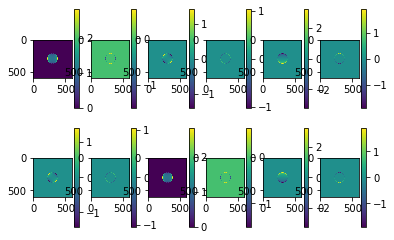

In [3]:
dtype1 = tf.float64
dtype2 = tf.complex128

# calculate the electric basis; this function haven't involve phase mask
def calculate_Ebasis(z, z2, zh, N, wavelength, n1, n2, nh, NA, M, pix_size ):
    #sim-dipole
    lambda1 = wavelength
    dx_true = (pix_size/M); #image plane sampling
    dx = n1*dx_true  #due to Abbe sine condition, scale by imaging medium r.i. (see appendix of my journal club)
    dv = 1/(N*dx)   #pupil sampling, related to image plane by FFT
    
    #define pupil coordinates
    temp = np.linspace((-1/(2*dx)), (1/(2*dx)), num=N)
    eta, xi = np.meshgrid(temp,temp)
    xBFP = lambda1*eta 
    yBFP = lambda1*xi
    
    rho = np.sqrt(np.multiply(xBFP,xBFP)+np.multiply(yBFP,yBFP))
    phi = np.arctan2(yBFP,xBFP)
    rho_max = NA/n1  #pupil region of support determined by NA and imaging medium r.i.
    k1 = n1*(2*math.pi/lambda1);
    kh = nh*(2*math.pi/lambda1);
    k2 = n2*(2*math.pi/lambda1);
    
    theta1 = np.arcsin(rho,dtype='complex'); #theta in matched medium
    thetah = np.arcsin((n1/nh)*np.sin(theta1),dtype='complex')  #theta in thin film
    theta2 = np.arcsin((n1/n2)*np.sin(theta1),dtype='complex')     #theta in mismatched medium
    theta2 = np.real(theta2)-1j*abs(np.imag(theta2))
  
                        
    #Fresnel coefficients
#     tp_2h = 2*n2*np.divide(np.cos(theta2),(n2*np.cos(thetah) + nh*np.cos(theta2)))
#     ts_2h = 2*n2*np.divide(np.cos(theta2),(nh*np.cos(thetah) + n2*np.cos(theta2)))
#     tp_h1 = 2*nh*np.divide(np.cos(thetah),(nh*np.cos(theta1) + n1*np.cos(thetah)))
#     ts_h1 = 2*nh*np.divide(np.cos(thetah),(n1*np.cos(theta1) + nh*np.cos(thetah)))
    
#     rp_2h = np.divide((n2*np.cos(theta2) - nh*np.cos(thetah)),(n2*np.cos(theta2)+ nh*np.cos(thetah)))
#     rs_2h = np.divide((nh*np.cos(theta2) - n2*np.cos(thetah)),(nh*np.cos(theta2)+ n2*np.cos(thetah)))
#     rp_h1 = np.divide((nh*np.cos(thetah) - n1*np.cos(theta1)),(nh*np.cos(thetah)+ n1*np.cos(theta1)))
#     rs_h1 = np.divide((n1*np.cos(thetah) - nh*np.cos(theta1)),(n1*np.cos(thetah)+ nh*np.cos(theta1)))
    
    tp_2h = 2*n2*np.cos(theta2)/(n2*np.cos(thetah) + nh*np.cos(theta2));
    ts_2h = 2*n2*np.cos(theta2)/(nh*np.cos(thetah) + n2*np.cos(theta2));
    tp_h1 = 2*nh*np.cos(thetah)/(nh*np.cos(theta1) + n1*np.cos(thetah));
    ts_h1 = 2*nh*np.cos(thetah)/(n1*np.cos(theta1) + nh*np.cos(thetah));

    rp_2h = (n2*np.cos(theta2) - nh*np.cos(thetah))/(n2*np.cos(theta2)+ nh*np.cos(thetah));
    rs_2h = (nh*np.cos(theta2) - n2*np.cos(thetah))/(nh*np.cos(theta2)+ n2*np.cos(thetah));
    rp_h1 = (nh*np.cos(thetah) - n1*np.cos(theta1))/(nh*np.cos(thetah)+ n1*np.cos(theta1));
    rs_h1 = (n1*np.cos(thetah) - nh*np.cos(theta1))/(n1*np.cos(thetah)+ nh*np.cos(theta1));
  
    #Axelrod's equations for E-fields in back focal plane
    #tp = np.divide(np.multiply(np.multiply(tp_2h,tp_h1),np.exp(1j*kh*np.cos(thetah)*zh)),1+np.multiply(np.multiply(rp_2h,rp_h1),np.exp(2j*kh*zh*np.cos(thetah))))
    #ts = np.divide(np.multiply(np.multiply(ts_2h,ts_h1),np.exp(1j*kh*np.cos(thetah)*zh)),1+np.multiply(np.multiply(rs_2h,rs_h1),np.exp(2j*kh*zh*np.cos(thetah))))
    
    tp = tp_2h*tp_h1*np.exp(1j*kh*np.cos(thetah)*zh)/(1 + rp_2h*rp_h1*np.exp(2j*kh*zh*np.cos(thetah)))
    ts = ts_2h*ts_h1*np.exp(1j*kh*np.cos(thetah)*zh)/(1 + rs_2h*rs_h1*np.exp(2j*kh*zh*np.cos(thetah)))

    #polirized electric field    
    Esx = np.multiply(np.multiply(ts,np.divide(np.cos(theta1),np.cos(theta2))),-(n1/n2)*(np.sin(phi)))
    Esy = np.multiply(np.multiply(ts,np.divide(np.cos(theta1),np.cos(theta2))),(n1/n2)*(np.cos(phi)))
    Epx = np.multiply(np.multiply(tp,np.cos(theta1)),(n1/n2)*(np.cos(phi)))
    Epy = np.multiply(np.multiply(tp,np.cos(theta1)),(n1/n2)*(np.sin(phi)))
    Epz = np.multiply(np.multiply(tp,np.divide(np.cos(theta1),np.cos(theta2))),((n1/n2)**2)*(-1)*np.sin(theta1))

    # Exx - Ex contributed by mux
    # the first x represents x channel and y channel on the camera, the second x,y,z represents the compoment of mux, muy, muz from the orientation of dipole
    temp1 = np.divide(1,np.sqrt(np.cos(theta1)))
    temp2 = np.multiply(np.cos(phi),Epx)-np.multiply(np.sin(phi),Esx)
    temp3 = np.multiply(np.cos(phi),Epy)-np.multiply(np.sin(phi),Esy)
    temp4 = np.multiply(np.cos(phi),Epz)
    temp5 = np.multiply(np.cos(phi),Esx)+np.multiply(np.sin(phi),Epx)
    temp6 = np.multiply(np.cos(phi),Esy)+np.multiply(np.sin(phi),Epy)
    temp7 = np.multiply(np.sin(phi),Epz)
    temp8 = np.multiply(np.multiply(np.exp(1j*k1*z*np.cos(theta1)),np.exp(1j*kh*zh*np.cos(thetah))),np.exp(1j*k2*z2*np.cos(theta2)))
    Exx = np.multiply(np.multiply(temp1,temp2),temp8)
    Exy = np.multiply(np.multiply(temp1,temp3),temp8)
    Exz = np.multiply(np.multiply(temp1,temp4),temp8)
    Eyx = np.multiply(np.multiply(temp1,temp5),temp8)
    Eyy = np.multiply(np.multiply(temp1,temp6),temp8)
    Eyz = np.multiply(np.multiply(temp1,temp7),temp8)
    
    
    # remove the electric component that is outside the accecptant region of objective lens
    Exx[rho >= rho_max] = 0;
    Exy[rho >= rho_max] = 0;
    Exz[rho >= rho_max] = 0;
    Eyx[rho >= rho_max] = 0;
    Eyy[rho >= rho_max] = 0;
    Eyz[rho >= rho_max] = 0;


 #   coord flipping
    Exx = np.rot90(Exx);
    Exy = np.rot90(Exy);
    Exz = np.rot90(Exz);
    Eyx = np.fliplr(Eyx);
    Eyy = np.fliplr(Eyy);
    Eyz = np.fliplr(Eyz);
    
  

    return Exx, Exy,Exz,Eyx,Eyy,Eyz;

Exx,Exy,Exz,Eyx,Eyy,Eyz = calculate_Ebasis(0, 0, 0, sampling_size, wavelength, n1, n2, nh, NA, Magnitude, pix_size)

Exx=tf.convert_to_tensor(Exx, dtype = dtype2)
Exy=tf.convert_to_tensor(Exy, dtype = dtype2)
Exz=tf.convert_to_tensor(Exz, dtype = dtype2)
Eyx=tf.convert_to_tensor(Eyx, dtype = dtype2)
Eyy=tf.convert_to_tensor(Eyy, dtype = dtype2)
Eyz=tf.convert_to_tensor(Eyz, dtype = dtype2)


plt.subplot(2,6,1)
plt.imshow(np.real(Exx))
plt.colorbar()

plt.subplot(2,6,2)
plt.imshow(np.imag(Exx))
plt.colorbar()

plt.subplot(2,6,3)
plt.imshow(np.real(Exy))
plt.colorbar()

plt.subplot(2,6,4)
plt.imshow(np.imag(Exy))
plt.colorbar()

plt.subplot(2,6,5)
plt.imshow(np.real(Exz))
plt.colorbar()

plt.subplot(2,6,6)
plt.imshow(np.imag(Exz))
plt.colorbar()

plt.subplot(2,6,7)
plt.imshow(np.real(Eyx))
plt.colorbar()

plt.subplot(2,6,8)
plt.imshow(np.imag(Eyx))
plt.colorbar()

plt.subplot(2,6,9)
plt.imshow(np.real(Eyy))
plt.colorbar()

plt.subplot(2,6,10)
plt.imshow(np.imag(Eyy))
plt.colorbar()

plt.subplot(2,6,11)
plt.imshow(np.real(Eyz))
plt.colorbar()

plt.subplot(2,6,12)
plt.imshow(np.imag(Eyz))
plt.colorbar()

 

(b) calculate the basis image with the electric basis. all the following is in the form of tensor

In [4]:
def angle2M_2(dipole):
    mux = tf.math.sin(dipole[0])*tf.math.cos(dipole[1])
    muy = tf.math.sin(dipole[0])*tf.math.sin(dipole[1])
    muz = tf.math.cos(dipole[0])
    gamma =  (tf.math.cos(dipole[2])**2+tf.math.cos(dipole[2]))/2
    
    
    M2 = [gamma*mux**2+(1-gamma)/3,gamma*muy**2+(1-gamma)/3,gamma*muz**2+(1-gamma)/3,gamma*mux*muy,gamma*mux*muz,gamma*muy*muz]
    M2 = tf.reshape(M2,[1,6])
    return M2

def xyz2angle(x,y,z):
    theta = math.acos(z)
    phi = math.acos(x/(math.sin(theta)+10**-10))
    return theta,phi


def basis_calculation(Exx,Exy,Exz,Eyx,Eyy,Eyz,pmask):

#     E = scipy.io.loadmat('E.mat')
#     E = tf.Variable(E['E'],dtype=dtype2)
#     Exx = E[:,:,0]
#     Exy = E[:,:,1]
#     Exz = E[:,:,2]
#     Eyx = E[:,:,3]
#     Eyy = E[:,:,4]
#     Eyz = E[:,:,5]
    #for propagation from BFP E-field to image plane via tube-lens, paraxial approximation is in force.
    imgExx = tf.signal.fftshift(tf.signal.fft2d(tf.math.multiply(Exx,pmask)))
    imgExy = tf.signal.fftshift(tf.signal.fft2d(tf.math.multiply(Exy,pmask)))
    imgExz = tf.signal.fftshift(tf.signal.fft2d(tf.math.multiply(Exz,pmask)))
    imgEyx = tf.signal.fftshift(tf.signal.fft2d(tf.math.multiply(Eyx,pmask)))
    imgEyy = tf.signal.fftshift(tf.signal.fft2d(tf.math.multiply(Eyy,pmask)))
    imgEyz = tf.signal.fftshift(tf.signal.fft2d(tf.math.multiply(Eyz,pmask)))

    # coord flipping
    # axis 0 up and down; axis 1 left and right
    imgExx = tf.reverse(tf.reverse(tf.transpose(imgExx),axis=[0]),axis=[1])
    imgExy = tf.reverse(tf.reverse(tf.transpose(imgExy),axis=[0]),axis=[1])
    imgExz = tf.reverse(tf.reverse(tf.transpose(imgExz),axis=[0]),axis=[1])
    imgEyx = tf.reverse(imgEyx,axis=[0])
    imgEyy = tf.reverse(imgEyy,axis=[0])
    imgEyz = tf.reverse(imgEyz,axis=[0])

    #euqation from backer's paper Eq.22    


    # euqation from backer's paper Eq.22
    BxxX = tf.math.multiply(tf.math.abs(imgExx),tf.math.abs(imgExx))
    ByyX = tf.math.multiply(tf.math.abs(imgExy),tf.math.abs(imgExy))
    BzzX = tf.math.multiply(tf.math.abs(imgExz),tf.math.abs(imgExz))


    BxyX = 2*tf.math.real(tf.math.multiply(tf.math.conj(imgExx),imgExy))
    BxzX = 2*tf.math.real(tf.math.multiply(tf.math.conj(imgExx),imgExz))
    ByzX = 2*tf.math.real(tf.math.multiply(tf.math.conj(imgExy),imgExz))

    BxxY = tf.math.multiply(tf.math.abs(imgEyx),tf.math.abs(imgEyx))
    ByyY = tf.math.multiply(tf.math.abs(imgEyy),tf.math.abs(imgEyy))
    BzzY = tf.math.multiply(tf.math.abs(imgEyz),tf.math.abs(imgEyz))

    BxyY = 2*tf.math.real(tf.math.multiply(tf.math.conj(imgEyx),imgEyy))
    BxzY = 2*tf.math.real(tf.math.multiply(tf.math.conj(imgEyx),imgEyz))
    ByzY = 2*tf.math.real(tf.math.multiply(tf.math.conj(imgEyy),imgEyz))

    a = int(sampling_size/2-image_size/2)
    b = int(sampling_size/2+image_size/2)
    #norm_factor = tf.reduce_sum(BxxX+BxxY, [0, 1]);

    norm_factor = 1/3*tf.reduce_sum(BxxX+BxxY, [0, 1])+1/3*tf.reduce_sum(ByyX+ByyY, [0, 1])+1/3*tf.reduce_sum(BzzX+BzzY, [0, 1]);
    norm_factor = norm_factor*0.8109
    BxxX = BxxX[a:b,a:b] /norm_factor
    ByyX = ByyX[a:b,a:b] /norm_factor
    BzzX = BzzX[a:b,a:b] /norm_factor
    BxyX = BxyX[a:b,a:b] /norm_factor
    BxzX = BxzX[a:b,a:b] /norm_factor
    ByzX = ByzX[a:b,a:b] /norm_factor

    BxxY = BxxY[a:b,a:b] /norm_factor
    ByyY = ByyY[a:b,a:b] /norm_factor
    BzzY = BzzY[a:b,a:b] /norm_factor
    BxyY = BxyY[a:b,a:b] /norm_factor
    BxzY = BxzY[a:b,a:b] /norm_factor
    ByzY = ByzY[a:b,a:b] /norm_factor
    #set_trace()
    return BxxX,ByyX,BzzX,BxyX,BxzX,ByzX,BxxY,ByyY,BzzY,BxyY,BxzY,ByzY;

# I have checked the bases step by step. They are correct. The only different between the basese calculated here and those caculated in Matlab is the flipping of xz,yz bases. But this won't influent the result.

## part 3 build the whole model: final image generation with second excitation field moments and basis image

In [5]:
class Model(tf.keras.Model):
    
    def __init__(self):
        sampling_size = 596
        # initialization of the phase mask, only the phase information
        #self.phase_mask = tf.Variable(tf.random.uniform([sampling_size,sampling_size],dtype= dtype1)*2-1)
        self.phase_mask = tf.Variable(tf.zeros([sampling_size,sampling_size],dtype= dtype1))
        #B_file = scipy.io.loadmat('phase_mask_CRB_M_RImismatch_380signal_2bgrd_v10.mat')
        #self.phase_mask = tf.Variable(B_file['pmask'],dtype=dtype1)


    def __call__(self):
        #set_trace()
        phase_mask = self.phase_mask
        
        phase_mask = tf.dtypes.cast(phase_mask, tf.complex128)
        pmask = tf.math.exp(1j*phase_mask)

        
        BxxX,ByyX,BzzX,BxyX,BxzX,ByzX,BxxY,ByyY,BzzY,BxyY,BxzY,ByzY = basis_calculation(Exx,Exy,Exz,Eyx,Eyy,Eyz,pmask)
        BxxXtemp = tf.reshape(BxxX,[1,int(image_size*image_size)])
        ByyXtemp = tf.reshape(ByyX,[1,int(image_size*image_size)])
        BzzXtemp = tf.reshape(BzzX,[1,int(image_size*image_size)]) 
        BxyXtemp = tf.reshape(BxyX,[1,int(image_size*image_size)])
        BxzXtemp = tf.reshape(BxzX,[1,int(image_size*image_size)]) 
        ByzXtemp = tf.reshape(ByzX,[1,int(image_size*image_size)])
        BXtemp = tf.concat([BxxXtemp,ByyXtemp,BzzXtemp,BxyXtemp,BxzXtemp,ByzXtemp],0)

        BxxYtemp = tf.reshape(BxxY,[1,int(image_size*image_size)]) 
        ByyYtemp = tf.reshape(ByyY,[1,int(image_size*image_size)]) 
        BzzYtemp = tf.reshape(BzzY,[1,int(image_size*image_size)]) 
        BxyYtemp = tf.reshape(BxyY,[1,int(image_size*image_size)]) 
        BxzYtemp = tf.reshape(BxzY,[1,int(image_size*image_size)]) 
        ByzYtemp = tf.reshape(ByzY,[1,int(image_size*image_size)]) 
        BYtemp = tf.concat([BxxYtemp,ByyYtemp,BzzYtemp,BxyYtemp,BxzYtemp,ByzYtemp],0)

        Basis_matrix = tf.concat([BXtemp,BYtemp],1)
        
        return Basis_matrix


## part 4: Loss function:

(1) VUB_3D; 
(2) CRB of MSAE  --- be choosen as the loss function in this code
(3) CRB of second moments 

Some orientation states are choosen for optimization
theta = [30,60,90] degree
phi = [0,45,90,135] degree
alpha  = [10,30,60,80] degree
 

In [82]:
# VUB 3D as the cost function
def VUB_3D(Basis_matrix):
#     set_trace()
    Basis_matrix = Basis_matrix[0:6,:]
    A = tf.math.divide(Basis_matrix,tf.math.sqrt(tf.norm(Basis_matrix,axis=0)+background/signal))
    FI = tf.linalg.matmul(A,tf.transpose(A))*signal
    Gamma = tf.linalg.inv(FI)
    Gamma_sum = tf.linalg.trace(Gamma)
    #Gamma_sum = tf.linalg.det(Gamma)
    return Gamma_sum


In [83]:
# CRLB cost function in estimating the \delta phi and \delta theta
def CRB_calculation2(Basis_matrix):
    d_theta = 10**(-6)
    d_phi = 10**(-6)
    d_alpha = 10**(-6)

    d_theta_m = tf.constant([d_theta,0,0.],dtype = dtype1)
    d_phi_m = tf.constant([0,d_phi,0.],dtype = dtype1)
    d_alpha_m = tf.constant([0,0,d_alpha],dtype = dtype1)
    #set_trace()
    # original
    
    # the orientation state be choosen for optimization
    #theta = np.array([30,60,90])*math.pi/180
    #theta = np.array([10,30,60,70,80,90])*math.pi/180  #for CRBangle v4 sampling
    #theta = np.array([10,30,60,90])*math.pi/180   #for CRBangle v3 sampling
    theta = np.array([10,20,30,40,50,60,70,80,90])*math.pi/180   #for CRBangle v5 sampling
    #phi = np.array([0,45,90,135])*math.pi/180
    #phi = np.array([0,15,30,45,60,75,90,105,130,145,160,175])*math.pi/180   #for CRBangle v3&4 sampling
    phi = np.array([0,15,30,45,60,75,90,105,120,135,150,165,180,195,210,225,240,255,270,285,300,315,330,345])*math.pi/180   #for CRBangle v5 sampling
    #theta = np.array([90])*math.pi/180
    #alpha  = np.array([10,30,60,80])*math.pi/180  #for v1,v2,v3,v4
    alpha  = np.array([10,20,30,40,50,60,70,80])*math.pi/180  #for v5
    

    count = 0
    MSAE_all = 0
    MSAE = np.zeros([tf.shape(theta)[0]*tf.shape(phi)[0]*tf.shape(alpha)[0],1])
    for i in range(0,tf.shape(theta)[0]):
    #for i in range(0,1):
        theta_c = theta[i]
        for j in range(0,tf.shape(phi)[0]):
        #for j in range(0,1):
            phi_c = phi[j]
            for k in range(0,tf.shape(alpha)[0]):
                alpha_c = alpha[k]
                #set_trace()
                dipole = tf.constant([theta_c,phi_c,alpha_c],dtype = dtype1)

                #1
                dipole1 = dipole
                M_2 = angle2M_2(dipole1)
                #temp2 = tf.constant([1],dtype=tf.float64)
                I = signal*tf.linalg.matmul(M_2,Basis_matrix)+background

                #2
                dipole2 = dipole+d_phi_m
                M_2 = angle2M_2(dipole2)
                #temp2 = tf.constant([1],dtype=tf.float64)
                I_dTheta = signal*tf.linalg.matmul(M_2,Basis_matrix)+background


                #3
                dipole3 = dipole+d_theta_m
                M_2 = angle2M_2(dipole3)
                #temp2 = tf.constant([1],dtype=tf.float64)
                I_dPhi = signal*tf.linalg.matmul(M_2,Basis_matrix)+background
                
                #4
                dipole4 = dipole+d_alpha_m
                M_2 = angle2M_2(dipole4)
                #temp2 = tf.constant([1],dtype=tf.float64)
                I_dAlpha = signal*tf.linalg.matmul(M_2,Basis_matrix)+background

                I_grad_theta = ((I_dTheta-I)/d_theta)
                I_grad_phi = ((I_dPhi-I)/d_phi)
                I_grad_alpha = ((I_dAlpha-I)/d_alpha)

                FI11 = tf.reduce_sum(tf.math.truediv(tf.math.multiply(I_grad_theta,I_grad_theta),I),[0,1]) + 1e-10
                FI22 = tf.reduce_sum(tf.math.truediv(tf.math.multiply(I_grad_phi,I_grad_phi),I),[0,1]) + 1e-10
                FI33 = tf.reduce_sum(tf.math.truediv(tf.math.multiply(I_grad_alpha,I_grad_alpha),I),[0,1])+ 1e-10
                FI12 = tf.reduce_sum(tf.math.truediv(tf.math.multiply(I_grad_phi,I_grad_theta),I),[0,1])
                FI13 = tf.reduce_sum(tf.math.truediv(tf.math.multiply(I_grad_theta,I_grad_alpha),I),[0,1]) + 1e-10
                FI23 = tf.reduce_sum(tf.math.truediv(tf.math.multiply(I_grad_phi,I_grad_alpha),I),[0,1]) + 1e-10

                
                
                FI = ([[FI11,FI12,FI13],
                       [FI12,FI22,FI23],
                       [FI13,FI23,FI33]])
#                 FI = ([[FI22,FI23],
#                        [FI23,FI33]])
                CRB = tf.linalg.inv(FI)
                #MSAE = (tf.math.sin(dipole[0])**2)*CRB[1,1]+CRB[0,0]
                #MSAE[count] = (tf.math.sin(theta_c)**2)*CRB[1,1]+CRB[0,0]
                MSAE_all = MSAE_all+(tf.math.sin(theta_c)**2)*CRB[1,1]+CRB[0,0]+CRB[2,2]
                #MSAE_all = MSAE_all+(tf.math.sin(theta_c)**2)*CRB[0,0]+CRB[1,1]
                count = count+1
            #set_trace()
    return  MSAE_all

#CRB,FI,MSAE,MSAE_all = CRB_calculation2(contrast,Basis_matrix,E_2)

In [10]:
# CRLB cost function in estimating the \delta phi and \delta theta
# uniformly sampled space
def CRB_calculation3(Basis_matrix):
    d_theta = 10**(-6)
    d_phi = 10**(-6)
    d_alpha = 10**(-6)

    d_theta_m = tf.constant([d_theta,0,0.],dtype = dtype1)
    d_phi_m = tf.constant([0,d_phi,0.],dtype = dtype1)
    d_alpha_m = tf.constant([0,0,d_alpha],dtype = dtype1)
    #set_trace()
    # original
    
    
    x1 = np.linspace(-1,1,20)
    x2 = np.linspace(-1,1,20)
    X,Y = np.meshgrid(x1,x2)
    X[X**2+Y**2>=1] = math.nan
    Y[X**2+Y**2>=1] = math.nan

    x = 2*X*np.sqrt(1-X**2-Y**2)
    y = 2*Y*np.sqrt(1-X**2-Y**2)
    z = 1-2*(X**2+Y**2)
    x[z<0]=math.nan
    y[z<0]=math.nan
    z[z<0]=math.nan
    x = x.flatten().astype('float64')
    y = y.flatten().astype('float64')
    z = z.flatten().astype('float64')
    

    omega = np.linspace(0,2*math.pi-0.05,10)
    alpha = 2*np.sqrt(np.arcsin(omega/4/math.pi))
    alpha = alpha.astype('float32')
    #alpha = tf.convert_to_tensor(alpha,dtype=dtype1) 

    count = 0
    MSAE_all = 0
    #MSAE = np.zeros([20*20*10,1])
    #MSAE = np.zeros([tf.shape(theta)[0]*tf.shape(phi)[0]*tf.shape(alpha)[0],1])
    for i in range(0,x.shape[0]):
        x_cur = x[i]
        y_cur = y[i]
        z_cur = z[i]
        if math.isnan(x_cur)==0:
            theta_c,phi_c = xyz2angle(x_cur,y_cur,z_cur)
            for k in range(0,tf.shape(alpha)[0]):

                #print(k)
                
                alpha_c = alpha[k]
                dipole = tf.constant([theta_c,phi_c,alpha_c],dtype = dtype1)

                #1
                dipole1 = dipole
                M_2 = angle2M_2(dipole1)
                #temp2 = tf.constant([1],dtype=tf.float64)
                I = signal*tf.linalg.matmul(M_2,Basis_matrix)+background
                set_trace()
                #2
                dipole2 = dipole+d_phi_m
                M_2 = angle2M_2(dipole2)
                #temp2 = tf.constant([1],dtype=tf.float64)
                I_dTheta = signal*tf.linalg.matmul(M_2,Basis_matrix)+background


                #3
                dipole3 = dipole+d_theta_m
                M_2 = angle2M_2(dipole3)
                #temp2 = tf.constant([1],dtype=tf.float64)
                I_dPhi = signal*tf.linalg.matmul(M_2,Basis_matrix)+background
                
                #4
                dipole4 = dipole+d_alpha_m
                M_2 = angle2M_2(dipole4)
                #temp2 = tf.constant([1],dtype=tf.float64)
                I_dAlpha = signal*tf.linalg.matmul(M_2,Basis_matrix)+background

                I_grad_theta = ((I_dTheta-I)/d_theta)
                I_grad_phi = ((I_dPhi-I)/d_phi)
                I_grad_alpha = ((I_dAlpha-I)/d_alpha)

                FI11 = tf.reduce_sum(tf.math.truediv(tf.math.multiply(I_grad_theta,I_grad_theta),I),[0,1]) + 1e-10
                FI22 = tf.reduce_sum(tf.math.truediv(tf.math.multiply(I_grad_phi,I_grad_phi),I),[0,1]) + 1e-10
                FI33 = tf.reduce_sum(tf.math.truediv(tf.math.multiply(I_grad_alpha,I_grad_alpha),I),[0,1])+ 1e-10
                FI12 = tf.reduce_sum(tf.math.truediv(tf.math.multiply(I_grad_phi,I_grad_theta),I),[0,1])
                FI13 = tf.reduce_sum(tf.math.truediv(tf.math.multiply(I_grad_theta,I_grad_alpha),I),[0,1]) + 1e-10
                FI23 = tf.reduce_sum(tf.math.truediv(tf.math.multiply(I_grad_phi,I_grad_alpha),I),[0,1]) + 1e-10

                
                FI = ([[FI11,FI12,FI13],
                       [FI12,FI22,FI23],
                       [FI13,FI23,FI33]])
#                 FI = ([[FI22,FI23],
#                        [FI23,FI33]])
                #set_trace()
                CRB = tf.linalg.inv(FI)
                theta_c = np.array(theta_c,dtype='float64')
                #MSAE = (tf.math.sin(dipole[0])**2)*CRB[1,1]+CRB[0,0]
                MSAE = (tf.math.sin(theta_c)**2)*CRB[1,1]+CRB[0,0]+CRB[2,2]
                if MSAE<=100:
                    MSAE_all = MSAE_all+(tf.math.sin(theta_c)**2)*CRB[1,1]+CRB[0,0]+CRB[2,2]
                #MSAE_all = MSAE_all+(tf.math.sin(theta_c)**2)*CRB[0,0]+CRB[1,1]
                count = count+1
            #set_trace()
    return  MSAE_all

#CRB,FI,MSAE,MSAE_all = CRB_calculation2(contrast,Basis_matrix,E_2)

In [6]:
# CRLB cost function in estimating the \delta phi and \delta theta
# uniformly sampled space
def CRB_M(Basis_matrix):
    warnings.filterwarnings("ignore",category =RuntimeWarning)
    x1 = np.linspace(-1,1,30)
    x2 = np.linspace(-1,1,30)
    X,Y = np.meshgrid(x1,x2)
    X[X**2+Y**2>=1] = math.nan
    Y[X**2+Y**2>=1] = math.nan

    x = 2*X*np.sqrt(1-X**2-Y**2)
    y = 2*Y*np.sqrt(1-X**2-Y**2)
    z = 1-2*(X**2+Y**2)
    x[z<0]=math.nan
    y[z<0]=math.nan
    z[z<0]=math.nan
    x = x.flatten().astype('float64')
    y = y.flatten().astype('float64')
    z = z.flatten().astype('float64')
    
   
    omega = np.linspace(0,2*math.pi,20)
    alpha = 2*np.sqrt(np.arcsin(omega/4/math.pi))
    alpha = alpha.astype('float32')
    #alpha = tf.convert_to_tensor(alpha,dtype=dtype1) 

    count = 0
    sigma_M_all = 0
    #MSAE = np.zeros([20*20*10,1])
    #MSAE = np.zeros([tf.shape(theta)[0]*tf.shape(phi)[0]*tf.shape(alpha)[0],1])
    for i in range(0,x.shape[0]):
        x_cur = x[i]
        y_cur = y[i]
        z_cur = z[i]
        if math.isnan(x_cur)==0:
            theta_c,phi_c = xyz2angle(x_cur,y_cur,z_cur)
            for k in range(0,tf.shape(alpha)[0]):

                #print(k)
                
                alpha_c = alpha[k]
                dipole = tf.constant([theta_c,phi_c,alpha_c],dtype = dtype1)
                #set_trace()
                #1
                dipole1 = dipole
                M_2 = angle2M_2(dipole1)
                #temp2 = tf.constant([1],dtype=tf.float64)
                I = signal*tf.linalg.matmul(M_2,Basis_matrix)+background
                basis_matrix_temp = Basis_matrix/I
                FI = signal**2*Basis_matrix@tf.transpose(basis_matrix_temp)
                sigma_M = (tf.linalg.det(FI)**(1/6))**(-1/2)

                sigma_M_all = sigma_M_all+sigma_M
                #MSAE_all = MSAE_all+(tf.math.sin(theta_c)**2)*CRB[0,0]+CRB[1,1]
                count = count+1
            #set_trace()
    return  sigma_M_all

#CRB,FI,MSAE,MSAE_all = CRB_calculation2(contrast,Basis_matrix,E_2)

## part 5:optimization process

In [7]:
start = time()
optimizer = tf.optimizers.Adam(0.05)
lost_save = np.array([])

def train(model):
    with tf.GradientTape() as t:
        temp1 = model()
        current_loss = CRB_M(temp1)
        #current_loss = CRB_calculation3(temp1)
        #current_loss = CRB_calculation_M(temp1)
        #current_loss = VUB_3D(temp1)
    grads = t.gradient(current_loss,[model.phase_mask])
    optimizer.apply_gradients(zip(grads,[model.phase_mask]))
    return model.phase_mask,current_loss

model = Model()
for i in range(300):
    # print(model.b.numpy())
    model.phase_mask,current_loss=train(model)
    lost_save = np.append(lost_save,current_loss)
    print(current_loss,i)

end = time()
elapsed = end-start


## part 6: evaluation the optimization result

tf.Tensor(445.5673050035656, shape=(), dtype=float64) 0
tf.Tensor(395.17559153679457, shape=(), dtype=float64) 1
tf.Tensor(358.97352405536134, shape=(), dtype=float64) 2
tf.Tensor(333.83192397420106, shape=(), dtype=float64) 3
tf.Tensor(316.041144031684, shape=(), dtype=float64) 4
tf.Tensor(303.1573852911838, shape=(), dtype=float64) 5
tf.Tensor(293.65082392230266, shape=(), dtype=float64) 6
tf.Tensor(286.5369851336556, shape=(), dtype=float64) 7
tf.Tensor(281.1566798301358, shape=(), dtype=float64) 8
tf.Tensor(277.05214167109204, shape=(), dtype=float64) 9
tf.Tensor(273.8960712593558, shape=(), dtype=float64) 10
tf.Tensor(271.4494185397138, shape=(), dtype=float64) 11
tf.Tensor(269.5350996648568, shape=(), dtype=float64) 12
tf.Tensor(268.02081921327203, shape=(), dtype=float64) 13
tf.Tensor(266.8073064012411, shape=(), dtype=float64) 14
tf.Tensor(265.81993275914834, shape=(), dtype=float64) 15
tf.Tensor(265.00255884300435, shape=(), dtype=float64) 16
tf.Tensor(264.3129307093902, shape

# Analyze the optimized phase mask

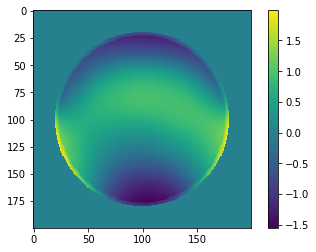

In [8]:
phase_mask_opt = tf.convert_to_tensor(model.phase_mask)
#phase_mask_opt = tf.zeros([sampling_size,sampling_size])
phase_size = 200
a = int(sampling_size/2-phase_size/2);
b = int(sampling_size/2+phase_size/2)
plt.imshow(phase_mask_opt[a:b,a:b])
plt.colorbar()
phase_mask_opt_save = phase_mask_opt;
phase_mask_opt = tf.dtypes.cast(phase_mask_opt, tf.complex128)
pmask_opt = tf.math.exp(1j*phase_mask_opt)
BxxX,ByyX,BzzX,BxyX,BxzX,ByzX,BxxY,ByyY,BzzY,BxyY,BxzY,ByzY = basis_calculation(Exx, Exy,Exz,Eyx,Eyy,Eyz,pmask_opt)
BxxXtemp = tf.reshape(BxxX,[1,int(image_size*image_size)])
ByyXtemp = tf.reshape(ByyX,[1,int(image_size*image_size)])
BzzXtemp = tf.reshape(BzzX,[1,int(image_size*image_size)]) 
BxyXtemp = tf.reshape(BxyX,[1,int(image_size*image_size)])
BxzXtemp = tf.reshape(BxzX,[1,int(image_size*image_size)]) 
ByzXtemp = tf.reshape(ByzX,[1,int(image_size*image_size)])
BXtemp = tf.concat([BxxXtemp,ByyXtemp,BzzXtemp,BxyXtemp,BxzXtemp,ByzXtemp],0)

BxxYtemp = tf.reshape(BxxY,[1,int(image_size*image_size)]) 
ByyYtemp = tf.reshape(ByyY,[1,int(image_size*image_size)]) 
BzzYtemp = tf.reshape(BzzY,[1,int(image_size*image_size)]) 
BxyYtemp = tf.reshape(BxyY,[1,int(image_size*image_size)]) 
BxzYtemp = tf.reshape(BxzY,[1,int(image_size*image_size)]) 
ByzYtemp = tf.reshape(ByzY,[1,int(image_size*image_size)]) 
BYtemp = tf.concat([BxxYtemp,ByyYtemp,BzzYtemp,BxyYtemp,BxzYtemp,ByzYtemp],0)

Basis_matrix = tf.concat([BXtemp,BYtemp],1)

#MSAE_all = CRB_calculation3(Basis_matrix)        
  

#plt.savefig('phase_mask_3D_MSAE.png')

In [17]:
MSE[21:40]

NameError: name 'MSE' is not defined

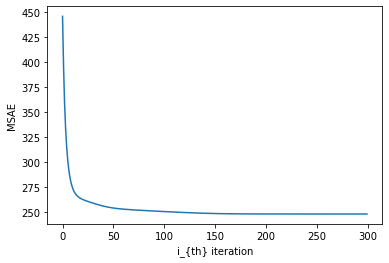

In [9]:
plt.plot(lost_save)
plt.xlabel("i_{th} iteration")
plt.ylabel("MSAE")
plt.savefig('lost_function.png')

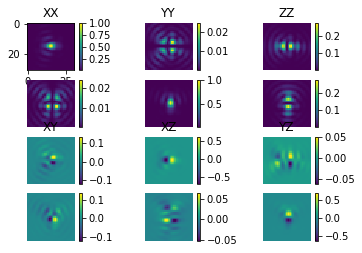

In [10]:
# basis image for simulated phase mask

BxxXtemp = tf.reshape(BxxX,[1,int(image_size*image_size)])
ByyXtemp = tf.reshape(ByyX,[1,int(image_size*image_size)])
BzzXtemp = tf.reshape(BzzX,[1,int(image_size*image_size)]) 
BxyXtemp = tf.reshape(BxyX,[1,int(image_size*image_size)])
BxzXtemp = tf.reshape(BxzX,[1,int(image_size*image_size)]) 
ByzXtemp = tf.reshape(ByzX,[1,int(image_size*image_size)])
BXtemp = tf.concat([BxxXtemp,ByyXtemp,BzzXtemp,BxyXtemp,BxzXtemp,ByzXtemp],0)

BxxYtemp = tf.reshape(BxxY,[1,int(image_size*image_size)]) 
ByyYtemp = tf.reshape(ByyY,[1,int(image_size*image_size)]) 
BzzYtemp = tf.reshape(BzzY,[1,int(image_size*image_size)]) 
BxyYtemp = tf.reshape(BxyY,[1,int(image_size*image_size)]) 
BxzYtemp = tf.reshape(BxzY,[1,int(image_size*image_size)]) 
ByzYtemp = tf.reshape(ByzY,[1,int(image_size*image_size)]) 
BYtemp = tf.concat([BxxYtemp,ByyYtemp,BzzYtemp,BxyYtemp,BxzYtemp,ByzYtemp],0)
Basis_matrix = tf.concat([BXtemp,BYtemp],1)

a = tf.math.reduce_max(Basis_matrix,[0,1])
BxxX,ByyX,BzzX,BxyX,BxzX,ByzX,BxxY,ByyY,BzzY,BxyY,BxzY,ByzY = BxxX/a,ByyX/a,BzzX/a,BxyX/a,BxzX/a,ByzX/a,BxxY/a,ByyY/a,BzzY/a,BxyY/a,BxzY/a,ByzY/a
plt.subplot(4,3,1)
plt.imshow((BxxX))
plt.colorbar()
plt.title('XX')

plt.subplot(4,3,2)
plt.imshow((ByyX))
plt.colorbar()
plt.title('YY')
plt.axis('off')


plt.subplot(4,3,3)
plt.imshow((BzzX))
plt.colorbar()
plt.title('ZZ')
plt.axis('off')


plt.subplot(4,3,4)
plt.imshow((BxxY))
plt.colorbar()
plt.axis('off')

plt.subplot(4,3,5)
plt.imshow((ByyY))
plt.colorbar()
plt.axis('off')


plt.subplot(4,3,6)
plt.imshow((BzzY))
plt.colorbar()
plt.axis('off')

plt.subplot(4,3,7)
plt.imshow((BxyX))
plt.colorbar()
plt.title('XY')
plt.axis('off')

plt.subplot(4,3,8)
plt.imshow((BxzX))
plt.colorbar()
plt.title('XZ')
plt.axis('off')

plt.subplot(4,3,9)
plt.imshow((ByzX))
plt.colorbar()
plt.title('YZ')
plt.axis('off')


plt.subplot(4,3,10)
plt.imshow((BxyY))
plt.colorbar()
plt.axis('off')

plt.subplot(4,3,11)
plt.imshow((BxzY))
plt.colorbar()
plt.axis('off')


plt.subplot(4,3,12)
plt.imshow((ByzY))
plt.colorbar()
plt.axis('off')

plt.savefig('basis_image.png')

## save optimized phase mask data

In [12]:
#phase_mask_opt
 # Save predictions to a matfile to open later in matlat
savename = 'phase_mask_CRB_M_RImismatch_1000signal_2bgrd_correct_error_minus_complex_term_v12.mat'
scipy.io.savemat(savename,{"pmask":phase_mask_opt_save.numpy()})
